In [32]:
#import modules
from imutils import paths
import random
from random import sample
import os
import numpy as np
import pandas as pd
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten
import tensorflow as tf
import PIL
import os
#!pip install scikit-learn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
#!pip install seaborn
import seaborn as sns
import shutil
#os.environ["XLA_FLAGS"] = "--xla_gpu_autotune_level=0"
#ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
#images path
images_dir="/home/andre/Desktop/Hippo/Original_data/Sorted_pictures"
images_paths = sorted(list(paths.list_images(images_dir)))


In [4]:
images_paths[0].split("/")[-2:][0]

'bird_facing'

In [5]:
#get a list with the types of the images by looking at the name in the directiory
images_types=[f.split("/")[-2:][0] for f in images_paths]

In [6]:
#get types
types_list=list(set(images_types))
types_list.sort()

In [7]:
types_list

['bird_facing',
 'side_bad',
 'side_clear',
 'side_empty',
 'side_head_inside',
 'top_bad',
 'top_clear',
 'top_empty',
 'top_head_inside']

In [8]:
#get also just the name of the pictures
images_names=[f.split("/")[-1:][0] for f in images_paths]

In [38]:
#convert types to numbers by using the index of the list >(i.e. 0 means bird_facing)
images_names_num=[str(types_list.index(f.split("/")[-2:][0])) for f in images_paths]
images_names_num[0:5]

['0', '0', '0', '0', '0']

In [39]:
#put into a df, it works because the lists are in the same order
images_df = pd.DataFrame(
    {'directories': images_paths,
     'names': images_names,
     'type': images_types,
     'type_num': images_names_num
    })

In [41]:
#erase duplicates
images_df=images_df.drop_duplicates(subset='names', keep="last")


In [42]:
#count types
summary_types = dict(Counter(images_df["type"].tolist()))
summary_types


{'bird_facing': 720,
 'side_bad': 843,
 'side_clear': 1023,
 'side_empty': 813,
 'side_head_inside': 953,
 'top_bad': 811,
 'top_clear': 849,
 'top_empty': 1019,
 'top_head_inside': 894}

In [13]:
#select 100 of each category for validation
val_images = images_df.groupby('type').head(100).reset_index(drop=True)


In [14]:
val_images

,directories,names,type,type_num
0,/home/andre/Desktop/Hippo/Original_data/Sorted...,3B0018233D_2024-12-08_12-33-25-725_1.jpg,bird_facing,0
1,/home/andre/Desktop/Hippo/Original_data/Sorted...,3B0018233D_2024-12-08_12-33-25-987_1.jpg,bird_facing,0
2,/home/andre/Desktop/Hippo/Original_data/Sorted...,3B0018233D_2024-12-08_12-35-34-013_1.jpg,bird_facing,0
3,/home/andre/Desktop/Hippo/Original_data/Sorted...,3B0018233D_2024-12-08_12-35-34-261_1.jpg,bird_facing,0
4,/home/andre/Desktop/Hippo/Original_data/Sorted...,3B0018233D_2024-12-08_12-35-34-512_1.jpg,bird_facing,0
...,...,...,...,...
895,/home/andre/Desktop/Hippo/Original_data/Sorted...,3B0018C750_2024-12-01_06-11-08-531_1.jpg,top_empty,7
896,/home/andre/Desktop/Hippo/Original_data/Sorted...,3B0018C750_2024-12-01_06-11-08-793_1.jpg,top_empty,7
897,/home/andre/Desktop/Hippo/Original_data/Sorted...,3B0018C750_2024-12-02_05-58-53-533_3.jpg,top_empty,7
898,/home/andre/Desktop/Hippo/Original_data/Sorted...,3B0018C750_2024-12-02_05-58-53-764_3.jpg,top_empty,7


In [15]:
#create the training dataset with the remaning by removing from the original df the ones that were selected for the val
train_images=images_df[~images_df["names"].isin(val_images["names"].tolist())]


In [16]:
#check for a balanced data
train_summary_types = dict(Counter(train_images["type"].tolist()))
train_summary_types


{'side_bad': 743,
 'side_clear': 923,
 'side_empty': 713,
 'side_head_inside': 853,
 'top_bad': 711,
 'top_head_inside': 794,
 'bird_facing': 620,
 'top_clear': 749,
 'top_empty': 919}

In [17]:
#we make copies of the categories with fewer images so that all have the maximum (in this case 923
for type in types_list:
    #number of pictures to make random copies
    num_sample=923-train_summary_types[type]
    filtered_df = train_images[train_images['type'] == type]
    sampled_rows = filtered_df.sample(n=num_sample, random_state=12)
    train_images=pd.concat([train_images,sampled_rows])


In [18]:
#check again for a balanced data
train_summary_types = dict(Counter(train_images["type"].tolist()))
train_summary_types


{'side_bad': 923,
 'side_clear': 923,
 'side_empty': 923,
 'side_head_inside': 923,
 'top_bad': 923,
 'top_head_inside': 923,
 'bird_facing': 923,
 'top_clear': 923,
 'top_empty': 923}

In [19]:
batch=4
train_data = ImageDataGenerator(rescale = 1./255)
train_generator_data=train_data.flow_from_dataframe(train_images,
                                x_col="directories",
                                y_col="type_num",
                                target_size = (224, 224),
                                #rotation_range=40,
                                #zoom_range=0.2,
                                batch_size=batch,
                                shuffle=True,
                                class_mode="sparse")

Found 8307 validated image filenames belonging to 9 classes.


In [20]:
val_data = ImageDataGenerator(rescale = 1./255)

val_generator_data=val_data.flow_from_dataframe(val_images,
                                x_col="directories",
                                y_col="type_num",
                                 target_size = (224, 224),
                                #rotation_range=40,
                                #zoom_range=0.2,
                                batch_size=batch,
                                shuffle=True,
                                class_mode="sparse")

Found 900 validated image filenames belonging to 9 classes.


In [21]:
print(len(summary_types))

9


In [22]:
print(len(images_types))

12590


In [23]:
#####TRY WITH OTHER networks:
#E.g. RESNET, efficientnet etc etc
#This one is if dont want to change the structure of the network
#load the pre-trained VGG19 from keras
vgg19 = VGG19(input_shape=(224,224,3), weights='imagenet', include_top=False)#input shape has to be the same as the generator above
x = vgg19.layers[-1].output
#add dropout and the full connected layers
#x = Dropout(0.5)(x) to overcome lack of data. Use when few images (<1000)
x = Flatten()(x)
#x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
#add a dense layer with a value equal to the number of classes
predictors = Dense(len(summary_types), activation='softmax')(x)###Last layer as to have number of categories

#
###NOTE if just two categoies use 1
#predictors = Dense(1, activation='sigmoid')(x)###Last layer as to have number of categories
#

# Create the model
model = Model(inputs=vgg19.input, outputs=predictors)

I0000 00:00:1741880355.097222   28575 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1201 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


In [24]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         2,31

 Total params: 26,449,481 (100.90 MB)

 Trainable params: 26,449,481 (100.90 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# define where to save the model after each epoch
filepath = "/home/andre/Desktop/Hippo/Models/Image_types/Image_types_ModelV1.h5"
# add a critera to save only if there was an improvement in the model comparing
# to the previous epoch (in this caset the model is saved if there was a decrease in the loss value)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# stop training if there is no improvement in model for 5 consecutives epochs.
early_stopping_monitor = EarlyStopping(patience=3)
callbacks_list = [checkpoint, early_stopping_monitor]

In [26]:
# Compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=1e-5),#learning rate usually -5 works the best for pre trained models. but -6 also sometimes
              metrics=['acc'])

In [27]:
import os
os.environ["XLA_FLAGS"] = "--xla_gpu_strict_conv_algorithm_picker=false"

history = model.fit(train_generator_data,
          steps_per_epoch=len(train_generator_data),
          epochs=10,
          validation_data=val_generator_data, 
          validation_steps=len(val_generator_data),
          callbacks=callbacks_list)

Epoch 1/10


/home/andre/anaconda3/envs/weavers_sexid_backup/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1741880363.424699   28721 service.cc:152] XLA service 0x646d52eae2d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741880363.424715   28721 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-03-13 15:39:23.464047: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741880363.777237   28721 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-03-13 15:39:24.72366

   2/2077 ━━━━━━━━━━━━━━━━━━━━ 2:57 86ms/step - acc: 0.0625 - loss: 3.2455     

I0000 00:00:1741880369.434892   28721 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 269/2077 ━━━━━━━━━━━━━━━━━━━━ 2:33 85ms/step - acc: 0.4025 - loss: 1.6898

2025-03-13 15:39:53.227256: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 898.56MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-03-13 15:39:54.718571: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 898.56MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


2077/2077 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - acc: 0.6458 - loss: 0.9709   

2025-03-13 15:42:30.518811: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 898.56MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.



Epoch 1: val_loss improved from inf to 0.64411, saving model to /home/andre/Desktop/Hippo/Models/Image_types/Image_types_ModelV1.h5


2077/2077 ━━━━━━━━━━━━━━━━━━━━ 194s 90ms/step - acc: 0.6458 - loss: 0.9707 - val_acc: 0.7633 - val_loss: 0.6441
Epoch 2/10
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - acc: 0.9026 - loss: 0.2826  
Epoch 2: val_loss did not improve from 0.64411
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 180s 87ms/step - acc: 0.9026 - loss: 0.2826 - val_acc: 0.7289 - val_loss: 0.8470
Epoch 3/10
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - acc: 0.9375 - loss: 0.1749  
Epoch 3: val_loss did not improve from 0.64411
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 180s 87ms/step - acc: 0.9375 - loss: 0.1749 - val_acc: 0.7622 - val_loss: 0.8042
Epoch 4/10
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - acc: 0.9531 - loss: 0.1315  
Epoch 4: val_loss did not improve from 0.64411
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 180s 87ms/step - acc: 0.9531 - loss: 0.1315 - val_acc: 0.7800 - val_loss: 0.8217


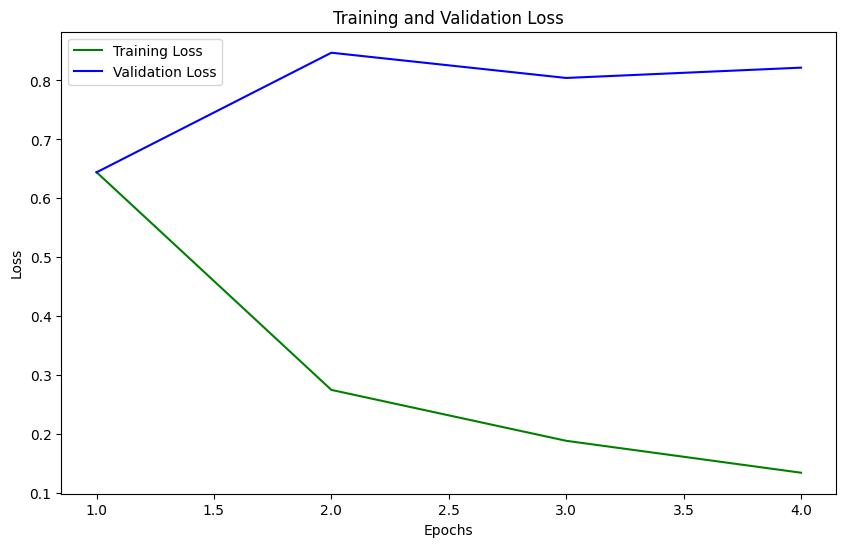

In [28]:
#pick up the example from the workshop to plot some examples of the predictions
#training loss vs validation loss plot
training_loss = history.history['loss'] #extract loss values at each epoch
validation_loss = history.history['val_loss']#extract accuracy values at each epoch

epochs = range(1, len(training_loss) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, label='Training Loss', color="green")
plt.plot(epochs, validation_loss, label='Validation Loss', color="blue")
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

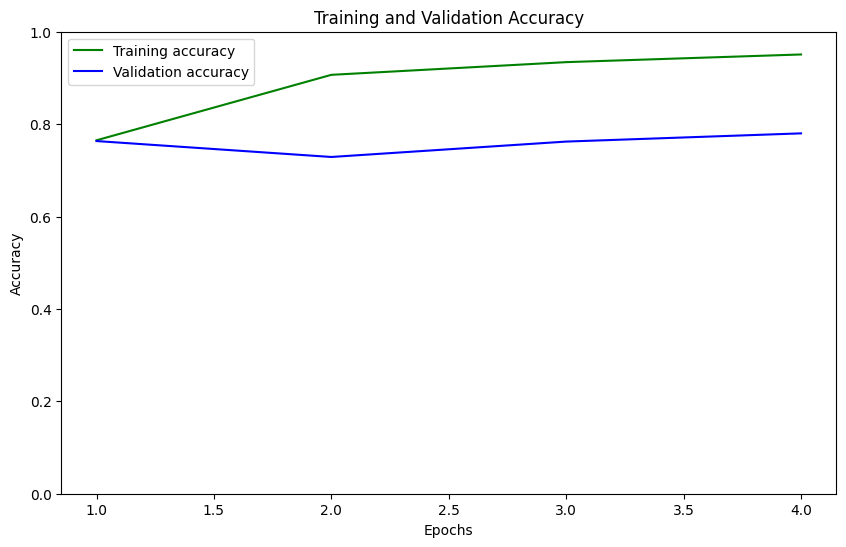

In [29]:
#training accuracy vs validation accuracy plot
training_loss = history.history['acc']
validation_loss = history.history['val_acc']

epochs = range(1, len(training_loss) + 1)
plt.figure(figsize=(10, 6))  # You can adjust the width (10) and height (6) as needed
plt.plot(epochs, training_loss, label='Training accuracy', color="green")
plt.plot(epochs, validation_loss, label='Validation accuracy', color="blue")
plt.ylim(0,1)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

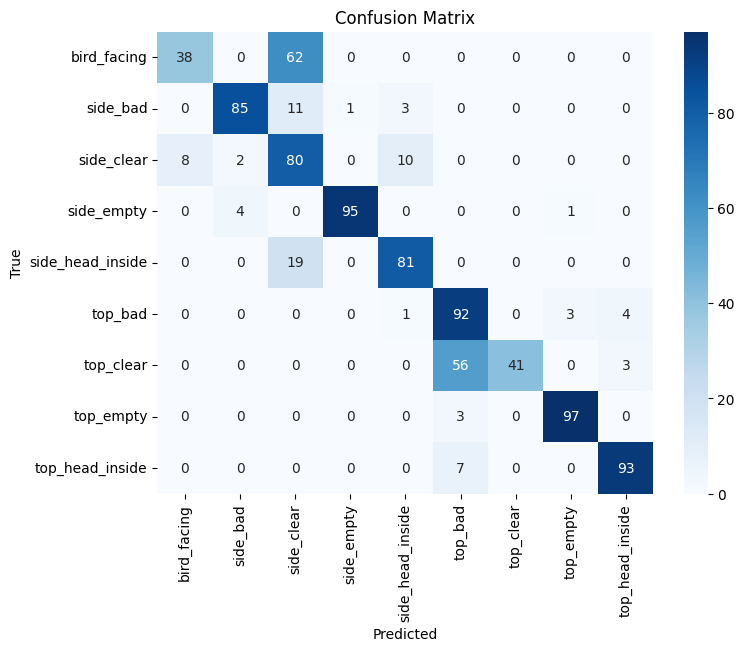

In [30]:
#make a confusion matrix to understand on the val dataset which are the most confused classes
#get the predicted labels and the true labels of the validation dataset
predicted_label=[]
true_label=[]
for step in range(len(val_generator_data)):
    X, y = next(val_generator_data)#generate image data and true label from the validation dataset
    results=model.predict(X, verbose=0)#predict the labels
    for i in range(0,len(results)):
      predicted_label.append(np.argmax(results[i]))#store predicted label
      true_label.append(int(y[i]))#store true labels

# Compute the confusion matrix
confusion = confusion_matrix(true_label, predicted_label)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=['bird_facing', 'side_bad', 'side_clear', 'side_empty', 'side_head_inside', 'top_bad', 'top_clear', 'top_empty', 'top_head_inside'], yticklabels=['bird_facing', 'side_bad', 'side_clear', 'side_empty', 'side_head_inside', 'top_bad', 'top_clear', 'top_empty', 'top_head_inside'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [34]:
results = model.predict(val_generator_data, verbose=1)
predicted_classes = np.argmax(results, axis=1)
true_classes = val_generator_data.classes
misclassified_indices = np.where(predicted_classes != true_classes)[0]
true_classes = np.array(val_generator_data.classes)
misclassified_indices = np.array(misclassified_indices)

filenames = val_generator_data.filenames
misclassified_images = [filenames[i] for i in misclassified_indices]
misclassified_df = pd.DataFrame({
    'image': misclassified_images,
    'true_label': true_classes[misclassified_indices],  
    'predicted_label': predicted_classes[misclassified_indices]
})


print(misclassified_df.head(10000).to_string(index=False))
output_dir = "/home/andre/Desktop/Hippo/Outputs"
for img_path in misclassified_images:
    src_path = os.path.join("/home/andre/Desktop/Hippo/Original_data", img_path) 
    dst_path = os.path.join(output_dir, os.path.basename(img_path))
    shutil.copy(src_path, dst_path)

print(f"Images mal classées copiées dans : {output_dir}")

225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step
                                                                                                                  image  true_label  predicted_label
     /home/andre/Desktop/Hippo/Original_data/Sorted_pictures/Col11/bird_facing/3B0018233D_2024-12-08_12-33-25-725_1.jpg           0                3
     /home/andre/Desktop/Hippo/Original_data/Sorted_pictures/Col11/bird_facing/3B0018233D_2024-12-08_12-33-25-987_1.jpg           0                2
     /home/andre/Desktop/Hippo/Original_data/Sorted_pictures/Col11/bird_facing/3B0018233D_2024-12-08_12-35-34-013_1.jpg           0                2
     /home/andre/Desktop/Hippo/Original_data/Sorted_pictures/Col11/bird_facing/3B0018233D_2024-12-08_12-35-34-261_1.jpg           0                2
     /home/andre/Desktop/Hippo/Original_data/Sorted_pictures/Col11/bird_facing/3B0018233D_2024-12-08_12-35-34-512_1.jpg           0                2
     /home/andre/Desktop/Hippo/Original_data/Sorted_pictures/Col

In [ ]:
for img_path, true_label, pred_label in zip(
    misclassified["image_directory"], misclassified["true_labels"], predicted_classes[misclassified.index]
):
    img = cv2.imread(img_path)  # Lire l'image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir en RGB

    plt.figure()
    plt.imshow(img)
    plt.title(f"Vrai : {true_label} - Prédit : {pred_label}")
    plt.axis("off")
    plt.show()

In [32]:
#try also with resnet
# Import necessary modules
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

# Load the pre-trained ResNet50 from keras
resnet50 = ResNet50(input_shape=(224,224,3), weights='imagenet', include_top=False)

# Use the output of the last layer
x = resnet50.layers[-1].output

# Flatten the output of the ResNet50 model
x = Flatten()(x)

# Add a fully connected layer
x = Dense(256, activation='relu')(x)

# Add a dense layer with the number of classes as the number of output units
predictors = Dense(len(types_list), activation='softmax')(x)

# Create the model
model = Model(inputs=resnet50.input, outputs=predictors)


In [33]:
#complete here dont forget to rename the model save dir
# define where to save the model after each epoch
filepath = "/home/andre/Desktop/Hippo/Models/Image_types/Image_types_ModelV2.h5"
# add a critera to save only if there was an improvement in the model comparing
# to the previous epoch (in this caset the model is saved if there was a decrease in the loss value)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# stop training if there is no improvement in model for 3 consecutives epochs.
early_stopping_monitor = EarlyStopping(patience=3)
callbacks_list = [checkpoint, early_stopping_monitor]

In [34]:
# Compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=1e-5),#learning rate usually -5 works the best for pre trained models. but -6 also sometimes
              metrics=['acc'])

In [35]:
import os
os.environ["XLA_FLAGS"] = "--xla_gpu_strict_conv_algorithm_picker=false"

history = model.fit(train_generator_data,
          steps_per_epoch=len(train_generator_data),
          epochs=10,
          validation_data=val_generator_data, 
          validation_steps=len(val_generator_data),
          callbacks=callbacks_list)

Epoch 1/10
  66/2068 ━━━━━━━━━━━━━━━━━━━━ 7:01 211ms/step - acc: 0.2813 - loss: 2.6194  

2025-03-13 13:24:50.158031: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_48', 12 bytes spill stores, 12 bytes spill loads



2068/2068 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - acc: 0.6686 - loss: 1.0271   
Epoch 1: val_loss improved from inf to 0.87060, saving model to /home/andre/Desktop/Hippo/Models/Image_types/Image_types_ModelV2.h5


2068/2068 ━━━━━━━━━━━━━━━━━━━━ 141s 58ms/step - acc: 0.6686 - loss: 1.0269 - val_acc: 0.7300 - val_loss: 0.8706
Epoch 2/10
2068/2068 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - acc: 0.9279 - loss: 0.2034  
Epoch 2: val_loss did not improve from 0.87060
2068/2068 ━━━━━━━━━━━━━━━━━━━━ 108s 52ms/step - acc: 0.9279 - loss: 0.2034 - val_acc: 0.7811 - val_loss: 0.9885
Epoch 3/10
2068/2068 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - acc: 0.9581 - loss: 0.1137  
Epoch 3: val_loss did not improve from 0.87060
2068/2068 ━━━━━━━━━━━━━━━━━━━━ 108s 52ms/step - acc: 0.9581 - loss: 0.1137 - val_acc: 0.7622 - val_loss: 1.1726
Epoch 4/10
2067/2068 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - acc: 0.9691 - loss: 0.0884  
Epoch 4: val_loss did not improve from 0.87060
2068/2068 ━━━━━━━━━━━━━━━━━━━━ 107s 52ms/step - acc: 0.9691 - loss: 0.0884 - val_acc: 0.7433 - val_loss: 1.6310


In [ ]:
#plot images also. Do the confusion matrix

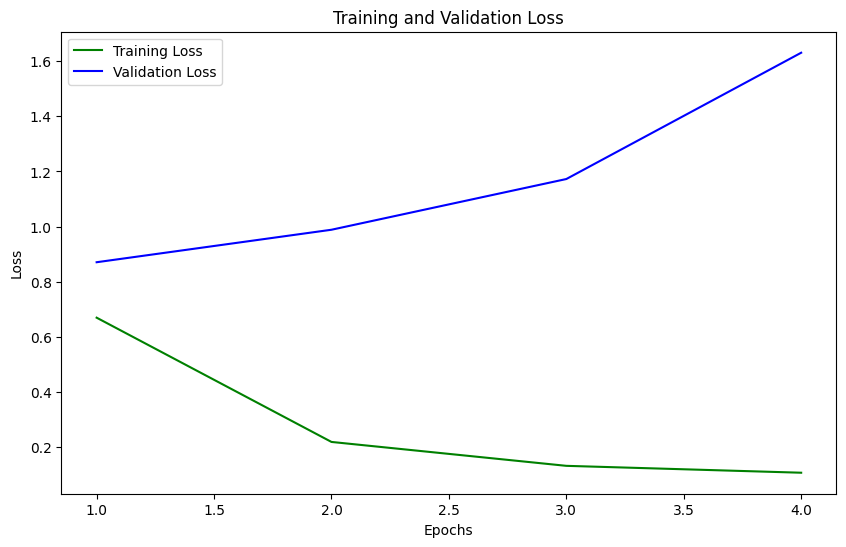

In [36]:
#training loss vs validation loss plot
training_loss = history.history['loss'] #extract loss values at each epoch
validation_loss = history.history['val_loss']#extract accuracy values at each epoch

epochs = range(1, len(training_loss) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, label='Training Loss', color="green")
plt.plot(epochs, validation_loss, label='Validation Loss', color="blue")
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

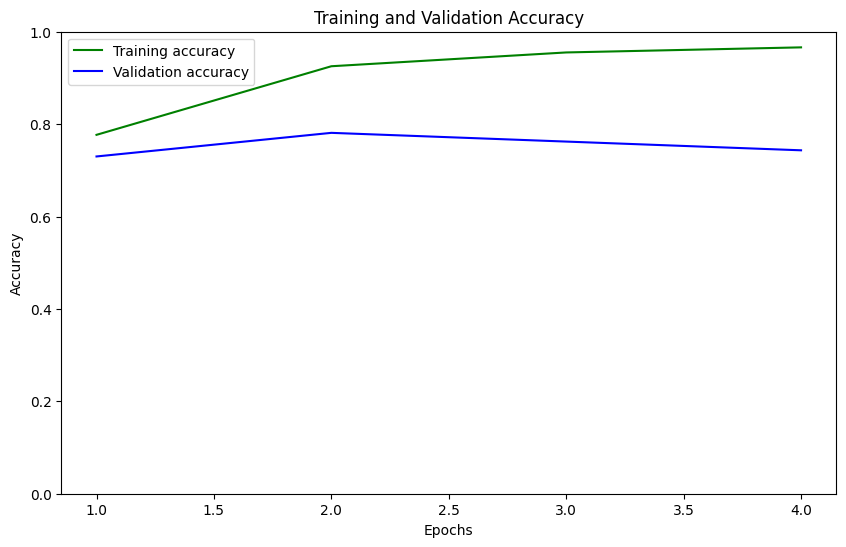

In [37]:
#training accuracy vs validation accuracy plot
training_loss = history.history['acc']
validation_loss = history.history['val_acc']

epochs = range(1, len(training_loss) + 1)
plt.figure(figsize=(10, 6))  # You can adjust the width (10) and height (6) as needed
plt.plot(epochs, training_loss, label='Training accuracy', color="green")
plt.plot(epochs, validation_loss, label='Validation accuracy', color="blue")
plt.ylim(0,1)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

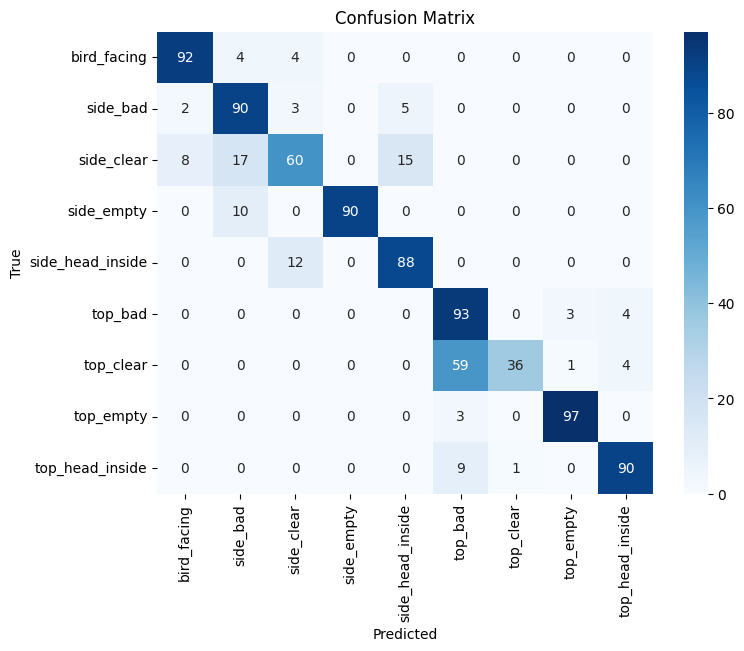

In [130]:
predicted_label=[]
true_label=[]
for step in range(len(val_generator_data)):
    X, y = next(val_generator_data)#generate image data and true label from the validation dataset
    results=model.predict(X, verbose=0)#predict the labels
    for i in range(0,len(results)):
      predicted_label.append(np.argmax(results[i]))#store predicted label
      true_label.append(int(y[i]))#store true labels

# Compute the confusion matrix
confusion = confusion_matrix(true_label, predicted_label)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=['bird_facing', 'side_bad', 'side_clear', 'side_empty', 'side_head_inside', 'top_bad', 'top_clear', 'top_empty', 'top_head_inside'], yticklabels=['bird_facing', 'side_bad', 'side_clear', 'side_empty', 'side_head_inside', 'top_bad', 'top_clear', 'top_empty', 'top_head_inside'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()